In [1]:
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Load and Preprocess the Dataset

In [ ]:
# Parameters
img_size = 128  # Resize images to 128x128
batch_size = 32

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load dataset
dataset_path = "./Data/Images-Dataset"  # Path to your dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check data labels
print("Class names:", dataset.classes)

Class names: ['Europeans', 'Indians', 'Orientals']


## Build the Diffusion Model

In [ ]:
from diffusers import DDPMScheduler, UNet2DModel
from torch.optim import Adam

# Load a pretrained model if available
model = UNet2DModel.from_pretrained("google/ddpm-cifar10-32")

# # Define the model
# model = UNet2DModel(
#     sample_size=img_size,  # Image size
#     in_channels=3,  # RGB images
#     out_channels=3,
#     layers_per_block=3, # Increase layers per block
#     block_out_channels=(128, 256, 512, 1024),
# )

# Define scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000, num_inference_steps=50)

# Define optimizer
optimizer = Adam(model.parameters(), lr=5e-5)

c:\Users\18435\.conda\envs\py309\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training the Diffusion Model

In [ ]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Training loop
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        noise = torch.randn_like(images).to(device)
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (images.shape[0],), device=device)
        noisy_images = scheduler.add_noise(images, noise, timesteps)
        
        # Forward pass
        optimizer.zero_grad()
        pred_noise = model(noisy_images, timesteps).sample
        loss = torch.nn.functional.mse_loss(pred_noise, noise)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    loss_values.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

cpu


100%|██████████| 47/47 [11:30<00:00, 14.70s/it]


Epoch 1/10, Loss: 0.3228819852179669


100%|██████████| 47/47 [11:42<00:00, 14.94s/it]


Epoch 2/10, Loss: 0.0963121124721588


100%|██████████| 47/47 [11:33<00:00, 14.75s/it]


Epoch 3/10, Loss: 0.0765311802004246


100%|██████████| 47/47 [11:33<00:00, 14.76s/it]


Epoch 4/10, Loss: 0.06111249985530021


100%|██████████| 47/47 [11:35<00:00, 14.80s/it]


Epoch 5/10, Loss: 0.053438282551917626


100%|██████████| 47/47 [11:40<00:00, 14.90s/it]


Epoch 6/10, Loss: 0.04843356900234172


100%|██████████| 47/47 [11:48<00:00, 15.08s/it]


Epoch 7/10, Loss: 0.040261883447144896


100%|██████████| 47/47 [11:13<00:00, 14.32s/it]


Epoch 8/10, Loss: 0.04155681777666224


100%|██████████| 47/47 [11:36<00:00, 14.82s/it]


Epoch 9/10, Loss: 0.03472715313050975


100%|██████████| 47/47 [11:31<00:00, 14.71s/it]

Epoch 10/10, Loss: 0.03162300800706478


## Saving the Model

In [6]:
# Save the model
model_save_path = "./diffusion_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'scheduler_state_dict': scheduler.state_dict(),
    'num_epochs': num_epochs
}, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./diffusion_model.pth


## Loading the Model

In [ ]:
# # Load the model
# model_save_path = "./diffusion_model.pth"
# checkpoint = torch.load(model_save_path)

# # Initialize model, optimizer, and scheduler
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# num_epochs = checkpoint['num_epochs']

# model.to(device)
# model.eval()  # Set model to evaluation mode
# print("Model loaded and ready for use!")

## Generating New Faces

In [11]:
def generate_images(group_combinations, num_images_per_combination=10):
    model.eval()
    generated_images = []
    
    with torch.no_grad():
        for group in group_combinations:
            for _ in range(num_images_per_combination):
                # Initialize random noise
                random_noise = torch.randn((1, 3, img_size, img_size), device=device)
                
                # Reverse diffusion process
                for t in reversed(range(scheduler.config.num_train_timesteps)):
                    timesteps = torch.tensor([t], device=device)
                    model_output = model(random_noise, timesteps).sample
                    
                    # Perform one reverse diffusion step
                    random_noise = scheduler.step(model_output=model_output, timestep=t, sample=random_noise).prev_sample

                # Collect generated image
                generated_images.append(random_noise)

    return generated_images

# Define group combinations
group_combinations = [
    "Orientals-Indians",
    "Orientals-Europeans",
    "Indians-Europeans",
    "Orientals-Indians-Europeans"
]

# Generate images
generated_images = generate_images(group_combinations)

## Plot Training and Testing Accuracy

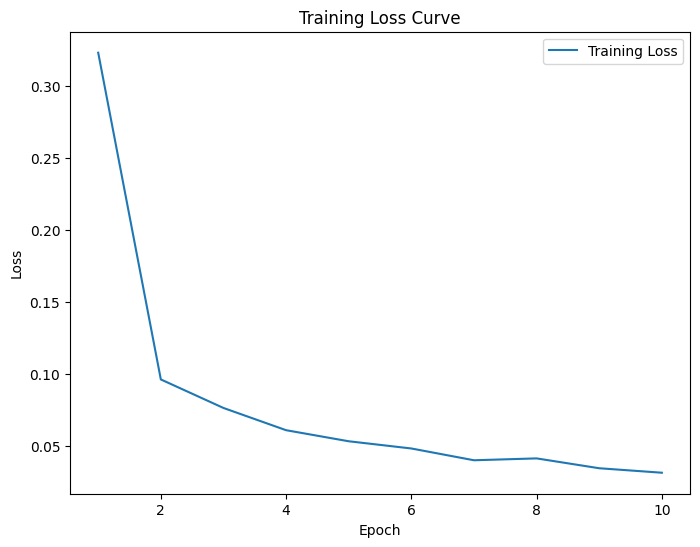

In [ ]:
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

## Visualize Generated Images

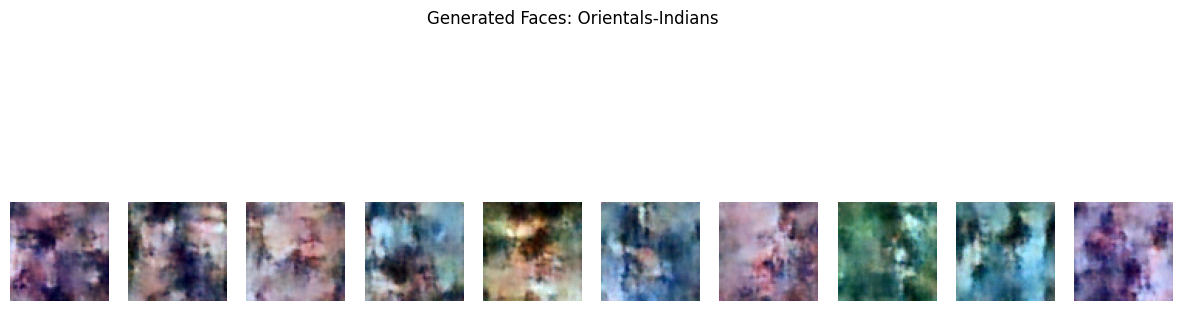

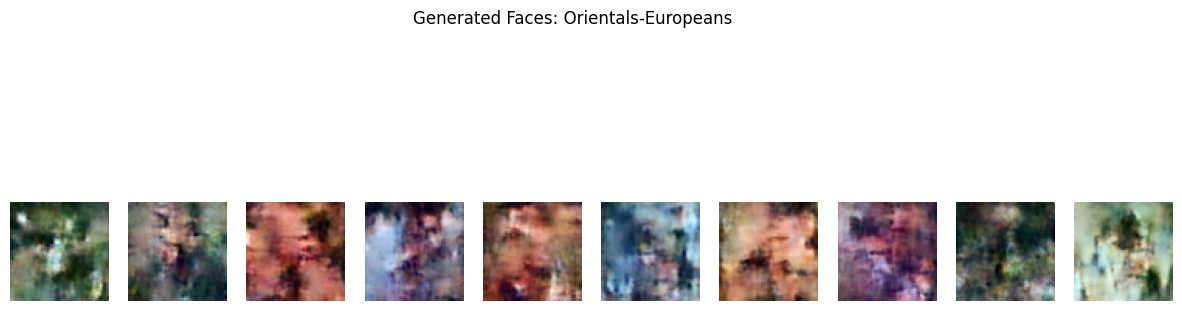

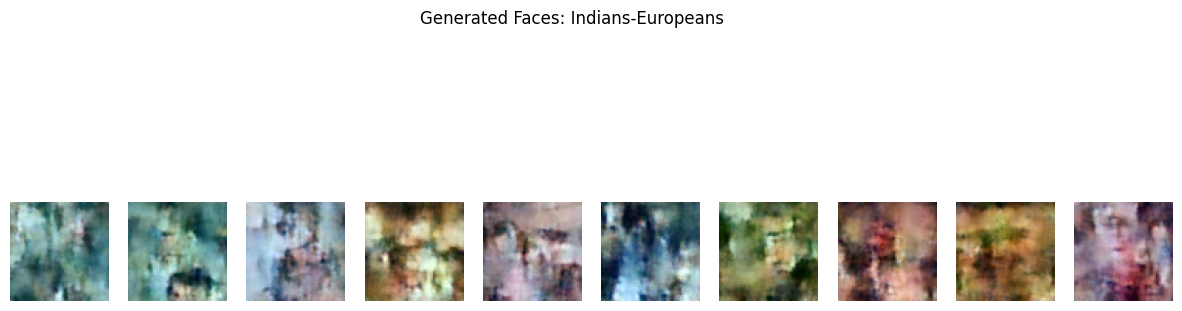

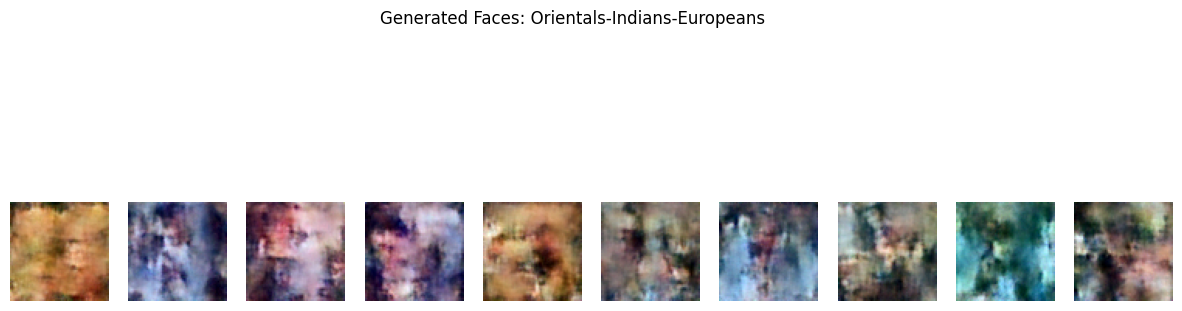

In [13]:
def show_images(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow((images[i].cpu().squeeze().permute(1, 2, 0) + 1) / 2)  # Denormalize
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

for idx, combination in enumerate(group_combinations):
    images = generated_images[idx * 10:(idx + 1) * 10]  # Extract specific combination
    show_images(images, title=f"Generated Faces: {combination}")